In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
# BASE_DIR = './17FlowerOxfordDataset'
train = './Dataset_CV/train'
val = './Dataset_CV/val'
test = './Dataset_CV/test'
N_CLUSTERS = 200

In [4]:
def extract_sift_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)
    return descriptors

In [5]:
def extract_sift_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)
    return descriptors

In [6]:
def extract_sift_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)
    return descriptors

In [7]:
def load_dataset(base_dir):
    data = []
    labels = []
    for label in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, label)
        if os.path.isdir(folder_path):
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                descriptors = extract_sift_features(img_path)
                if descriptors is not None:
                    data.append(descriptors)
                    labels.append(label)
    return data, labels

In [8]:
all_descriptors_train, labels_train = load_dataset(train)
all_descriptors_val, labels_val = load_dataset(val)
all_descriptors_test, labels_test = load_dataset(test)

In [9]:
all_descriptors_combined_train = np.vstack([desc for desc in all_descriptors_train if desc is not None])
kmeans = KMeans(n_clusters=N_CLUSTERS)
kmeans.fit(all_descriptors_combined_train)

KMeans(n_clusters=200)

In [10]:
all_descriptors_combined_val = np.vstack([desc for desc in all_descriptors_val if desc is not None])
kmeans = KMeans(n_clusters=N_CLUSTERS)
kmeans.fit(all_descriptors_combined_val)

KMeans(n_clusters=200)

In [11]:
all_descriptors_combined_test = np.vstack([desc for desc in all_descriptors_test if desc is not None])
kmeans = KMeans(n_clusters=N_CLUSTERS)
kmeans.fit(all_descriptors_combined_test)

KMeans(n_clusters=200)

In [12]:
def compute_histograms(descriptor_list, kmeans_model, n_clusters):
    histograms = []
    for descriptors in tqdm(descriptor_list):
        if descriptors is not None:
            histogram = np.zeros(n_clusters)
            clusters = kmeans_model.predict(descriptors)
            for cluster_idx in clusters:
                histogram[cluster_idx] += 1
            histograms.append(histogram)
        else:
            histograms.append(np.zeros(n_clusters))
    return np.array(histograms)

In [13]:
histograms_train = compute_histograms(all_descriptors_train, kmeans, N_CLUSTERS)

100%|██████████| 1088/1088 [00:02<00:00, 441.29it/s]


In [14]:
histograms_val = compute_histograms(all_descriptors_val, kmeans, N_CLUSTERS)

100%|██████████| 135/135 [00:00<00:00, 338.27it/s]


In [15]:
histograms_test = compute_histograms(all_descriptors_test, kmeans, N_CLUSTERS)

100%|██████████| 137/137 [00:00<00:00, 432.08it/s]


In [16]:
label_encoder = LabelEncoder()
encoded_labels_train = label_encoder.fit_transform(labels_train)
encoded_labels_val = label_encoder.fit_transform(labels_val)
encoded_labels_test = label_encoder.fit_transform(labels_test)

In [18]:
base_estimator = DecisionTreeClassifier(max_depth=15)
adaboost = AdaBoostClassifier(estimator=base_estimator, n_estimators=200)
adaboost.fit(histograms_train, encoded_labels_train)

c:\Users\Angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=15),
                   n_estimators=200)

In [19]:
y_pred_val = adaboost.predict(histograms_val)
accuracy_val = accuracy_score(labels_val, y_pred_val)

In [20]:
print("Classification Report:")
print(classification_report(encoded_labels_val, y_pred_val, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

    bluebell       0.25      0.12      0.17         8
   buttercup       1.00      0.38      0.55         8
     cowslip       0.50      0.50      0.50         8
      crocus       0.46      0.75      0.57         8
    daffodil       1.00      0.50      0.67         8
       daisy       1.00      0.75      0.86         8
   dandelion       0.67      0.75      0.71         8
  fritillary       0.86      0.75      0.80         8
        iris       0.83      0.62      0.71         8
       pansy       0.80      0.50      0.62         8
        rose       0.43      0.38      0.40         8
    snowdrop       0.31      0.56      0.40        16
   sunflower       0.86      0.86      0.86         7
  tiger lily       0.60      0.75      0.67         8
       tulip       0.30      0.38      0.33         8
  windflower       0.86      0.75      0.80         8

    accuracy                           0.58       135
   

In [21]:
y_pred_test = adaboost.predict(histograms_test)
accuracy_test = accuracy_score(labels_test, y_pred_test)

In [22]:
print("Classification Report:")
print(classification_report(encoded_labels_test, y_pred_test, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

    bluebell       0.25      0.12      0.17         8
   buttercup       1.00      0.38      0.55         8
     cowslip       0.67      0.50      0.57         8
      crocus       0.57      0.50      0.53         8
    daffodil       0.25      0.12      0.17         8
       daisy       1.00      0.67      0.80         9
   dandelion       0.62      1.00      0.76         8
  fritillary       0.83      0.62      0.71         8
        iris       0.60      0.75      0.67         8
       pansy       0.80      0.50      0.62         8
        rose       0.50      0.88      0.64         8
    snowdrop       0.36      0.75      0.49        16
   sunflower       0.67      0.50      0.57         8
  tiger lily       0.50      0.75      0.60         8
       tulip       1.00      0.38      0.55         8
  windflower       0.80      0.50      0.62         8

    accuracy                           0.57       137
   

In [23]:
# y_pred = adaboost.predict(X_test)

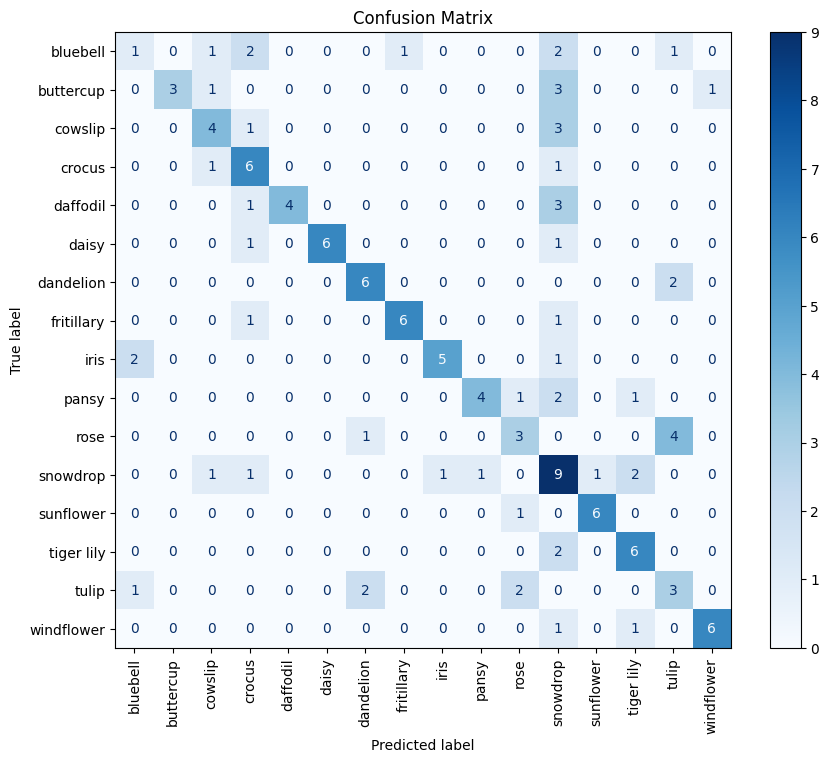

In [24]:
cm = confusion_matrix(encoded_labels_val, y_pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')

plt.title("Confusion Matrix")
plt.savefig('sift-adaboost-confusionmatrix.png')
plt.show()

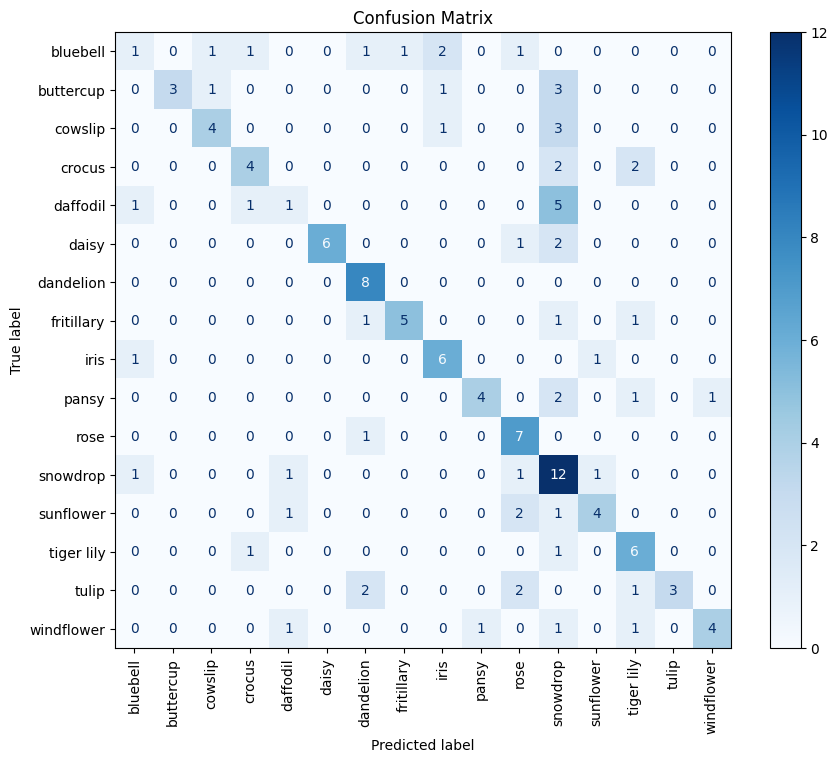

In [25]:
cm = confusion_matrix(encoded_labels_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')

plt.title("Confusion Matrix")
plt.savefig('sift-adaboost-confusionmatrix.png')
plt.show()

In [26]:
train_predictions = adaboost.predict(histograms_train)
val_predictions = adaboost.predict(histograms_val)
test_predictions = adaboost.predict(histograms_test)

In [27]:
train_accuracy = accuracy_score(encoded_labels_train, train_predictions)
val_accuracy = accuracy_score(encoded_labels_val, val_predictions)
test_accuracy = accuracy_score(encoded_labels_test, test_predictions)

print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Val Accuracy: {val_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Train Accuracy: 100.00%
Val Accuracy: 57.78%
Test Accuracy: 56.93%


c:\Users\Angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is 

c:\Users\Angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is 

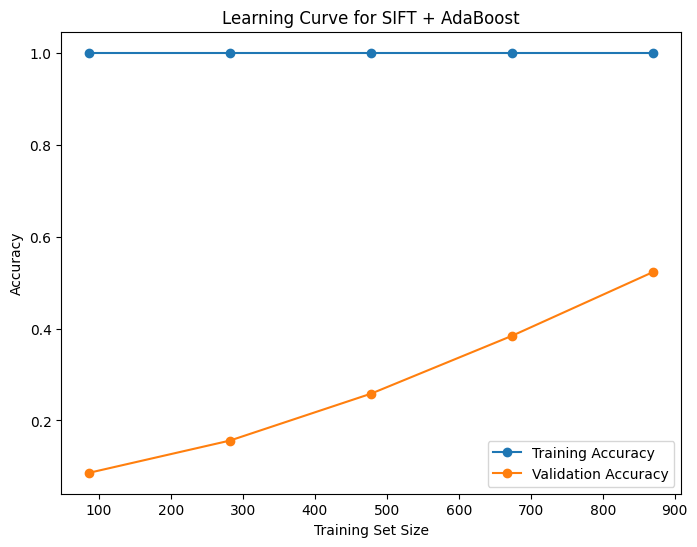

In [29]:
train_sizes, train_scores, val_scores = learning_curve(adaboost, histograms_train, encoded_labels_train, cv=5, scoring='accuracy')
train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training Accuracy", marker='o')
plt.plot(train_sizes, val_mean, label="Validation Accuracy", marker='o')
plt.title("Learning Curve for SIFT + AdaBoost")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.show()